In [70]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-08 10:24:21,685: Credentials are already in use. The existing account in the session will be replaced.


In [71]:
# error probabilties, I took the following value randomly
#wondering should I take them randomly
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
measure_error = 0.2 # P(measure error)
gate_error = 0.05 # P(two qubit error)

# calling error functions using from IBM library
re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
gate_err2 = gate_err1.tensor(gate_err1)

# errors on a noisy model
bitflip_err = NoiseModel()
bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")

print(bitflip_err)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'reset', 'u3', 'measure', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [72]:
def bit_error(circ):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error


    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    bitflip_err = NoiseModel()
    bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
    bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
    bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()

    legend = ['ideal', 'bit_flip']

    # Plot noisy output
    plot_bit = plot_histogram([ideal_counts, counts_bit_flip], legend= legend)
    return plot_bit

def ideal(circ):
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()

    
    return ideal_counts

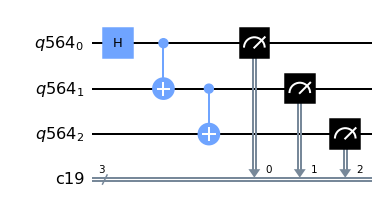

In [73]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

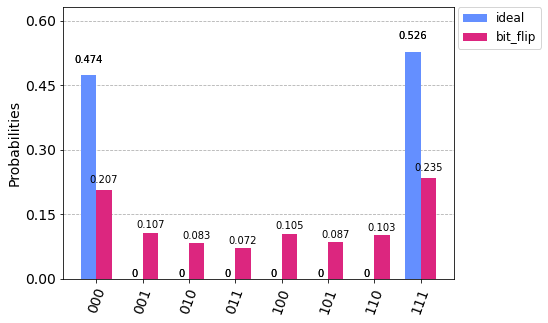

In [74]:
bit_error(ghz_circ)

In [75]:
def t1_t2(qubits, circ):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    
    # Run the noisy simulation
    sim_thermal = AerSimulator(noise_model=noise_thermal)

    # Transpile circuit for noisy basis gates
    tthermal = transpile(circ, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(tthermal).result()
    counts_thermal = result_thermal.get_counts()
    legend_t = ['ideal', 'thermal']

    # Plot noisy output
    plot_thermal = plot_histogram([ideal_counts, counts_thermal], legend= legend_t)
    
    return plot_thermal

    

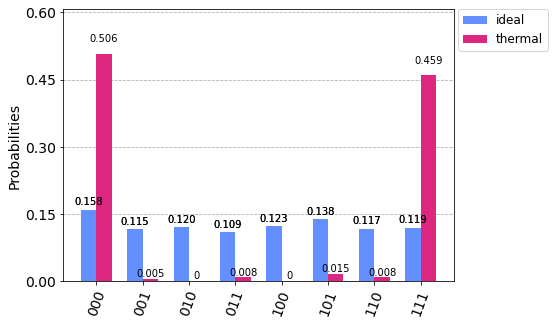

In [76]:
t1_t2(len(q_ghz), ghz_circ)

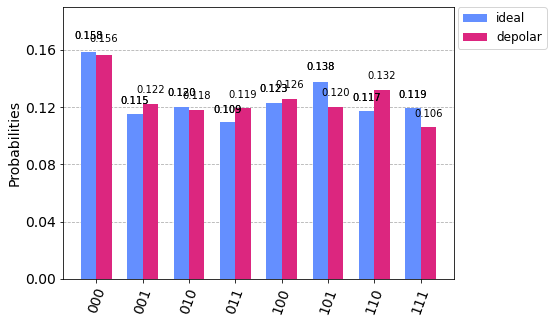

In [77]:
p_gate = 0.1
error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
error_gate1 = depolarizing_error(p_gate, 3)
error_gate2 = error_gate1.tensor(error_gate1)

noise_depolar = NoiseModel()
noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", 3)

# Run the noisy simulation
sim_depolar = AerSimulator(noise_model=noise_depolar)

# Transpile circuit for noisy basis gates
ghz_depolar = transpile(ghz_circ, sim_depolar)

# Run and get counts
result_depolar = sim_depolar.run(ghz_depolar).result()
counts_depolar = result_depolar.get_counts()
legend_t = ['ideal', 'depolar']

# Plot noisy output
plot_histogram([ideal_counts, counts_thermal], legend= legend_t)

In [78]:
print(noise_depolar)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  All-qubits errors: ['measure']


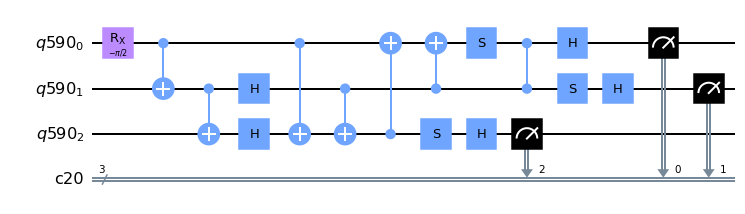

In [79]:
#Mermin_Bell gate
from math import pi
mer_bell = QuantumRegister(3)
mer_bell_c =  ClassicalRegister(3)
mer_bell_circ = QuantumCircuit(mer_bell, mer_bell_c)
mer_bell_circ.rx(-pi/2, mer_bell[0])
mer_bell_circ.cx(mer_bell[0], mer_bell[1])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cx(mer_bell[0], mer_bell[2])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.cx(mer_bell[2], mer_bell[0])
mer_bell_circ.cx(mer_bell[1], mer_bell[0])
mer_bell_circ.s(mer_bell[2])
mer_bell_circ.s(mer_bell[0])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cz(mer_bell[0], mer_bell[1])
mer_bell_circ.h(mer_bell[0])
mer_bell_circ.s(mer_bell[1])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.measure(mer_bell[0:3], mer_bell_c[0:3])
display(mer_bell_circ.draw())
                           

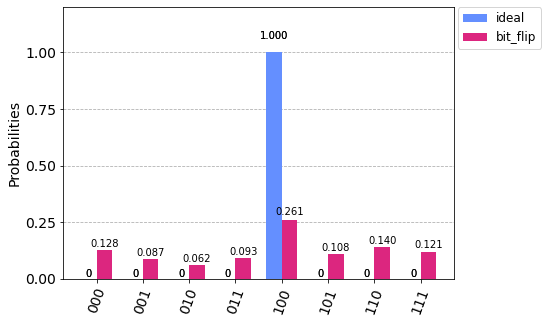

In [80]:
bit_error(mer_bell_circ)

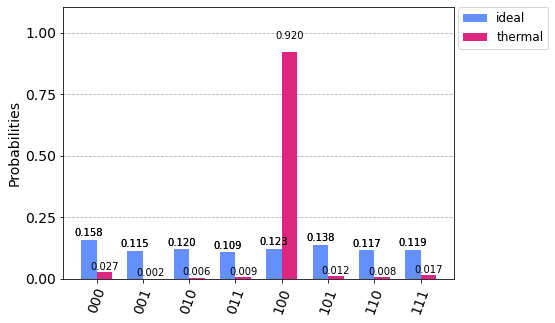

In [81]:
t1_t2(len(mer_bell), mer_bell_circ)


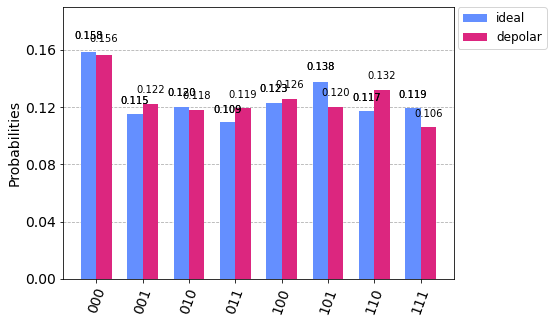

In [82]:
p_gate = 0.1
error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
error_gate1 = depolarizing_error(p_gate, 3)
error_gate2 = error_gate1.tensor(error_gate1)

noise_depolar = NoiseModel()
noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", 3)

# Run the noisy simulation
sim_depolar = AerSimulator(noise_model=noise_depolar)

# Transpile circuit for noisy basis gates
mer_depolar = transpile(mer_bell_circ, sim_depolar)

# Run and get counts
result_depolar = sim_depolar.run(mer_depolar).result()
counts_depolar = result_depolar.get_counts()
legend_t = ['ideal', 'depolar']

# Plot noisy output
plot_histogram([ideal_counts, counts_thermal], legend= legend_t)

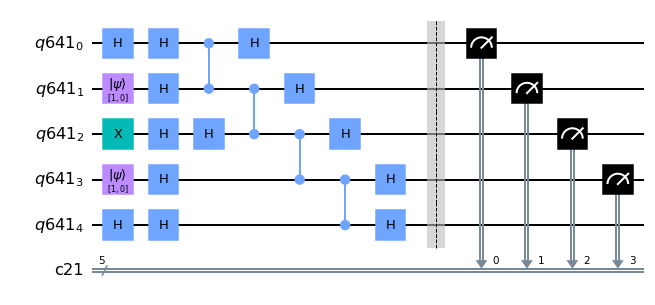

In [83]:
#phase code
phase_q = QuantumRegister(5)
phase_c = ClassicalRegister(5)
phase_circ = QuantumCircuit(phase_q, phase_c)
phase_circ.h(phase_q[0])
phase_circ.initialize([1,0], 1)
phase_circ.x(phase_q[2])
phase_circ.initialize([1,0], 3)
phase_circ.h(phase_q[4])
phase_circ.h(phase_q[0:5])
phase_circ.cz(phase_q[0], phase_q[1])
phase_circ.h(phase_q[2])
phase_circ.h(phase_q[0])
phase_circ.cz(phase_q[1], phase_q[2])
phase_circ.h(phase_q[1])
phase_circ.cz(phase_q[2], phase_q[3])
phase_circ.h(phase_q[2])
phase_circ.cz(phase_q[3], phase_q[4])
phase_circ.h(phase_q[3])
phase_circ.h(phase_q[4])
phase_circ.barrier()
phase_circ.measure(phase_q[0:4], phase_c[0:4])
display(phase_circ.draw())


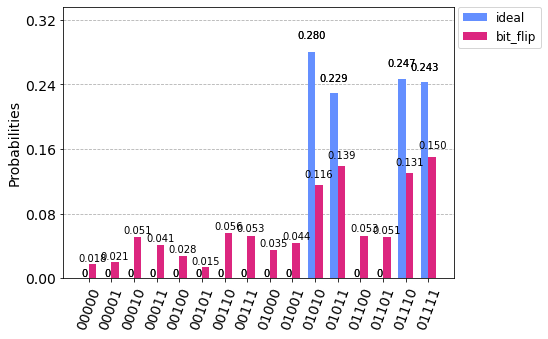

In [84]:
bit_error(phase_circ)

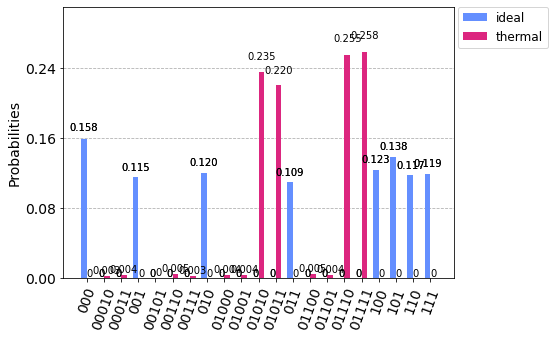

In [85]:
t1_t2(len(phase_q), phase_circ)

In [86]:
#p_gate = 0.1
#error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
#error_gate1 = depolarizing_error(p_gate, 5)
#error_gate2 = error_gate1.tensor(error_gate1)

#noise_depolar = NoiseModel()
#noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", 5)

# Run the noisy simulation
#sim_depolar = AerSimulator(noise_model=noise_depolar)

# Transpile circuit for noisy basis gates
#phase_depolar = transpile(phase_circ, sim_depolar)

# Run and get counts
#result_depolar = sim_depolar.run(phase_depolar).result()
#counts_depolar = result_depolar.get_counts()
#legend_t = ['ideal', 'depolar']

# Plot noisy output
#plot_histogram([ideal_counts, counts_thermal], legend= legend_t)

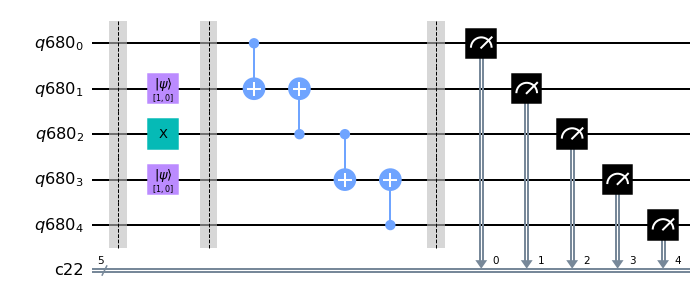

In [87]:
#bit code
bit_q  = QuantumRegister(5)
bit_c = ClassicalRegister(5)
bit_circ = QuantumCircuit(bit_q,bit_c)
bit_circ.barrier()
bit_circ.initialize([1,0], 1)
bit_circ.x(bit_q[2])
bit_circ.initialize([1,0], 3)
bit_circ.barrier()

bit_circ.cx(bit_q[0], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[3])
bit_circ.cx(bit_q[4], bit_q[3])
bit_circ.barrier()
bit_circ.measure(bit_q[0:5],bit_c[0:5])
display(bit_circ.draw())


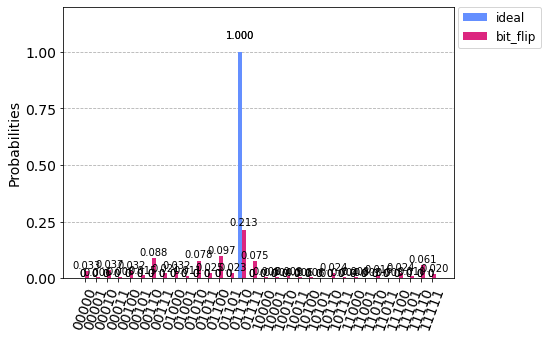

In [88]:
bit_error(bit_circ)

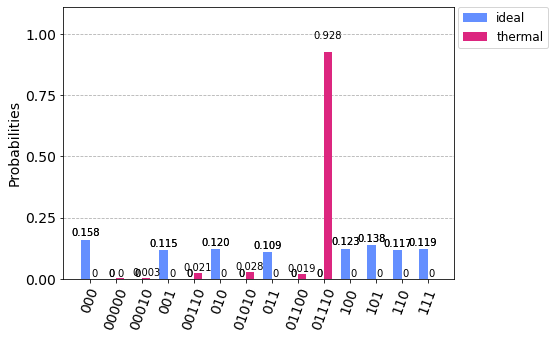

In [89]:
t1_t2(len(bit_q), bit_circ)

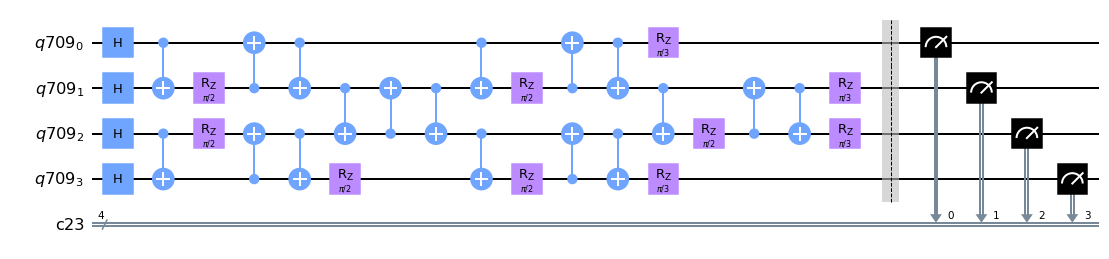

In [90]:
swap_qaoa_q = QuantumRegister(4)
swap_qaoa_c = ClassicalRegister(4)
swap_qaoa_circ = QuantumCircuit(swap_qaoa_q, swap_qaoa_c)
swap_qaoa_circ.h(swap_qaoa_q[0:4])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/3, 0)
swap_qaoa_circ.rz(np.pi/3, 1)
swap_qaoa_circ.rz(np.pi/3, 2)
swap_qaoa_circ.rz(np.pi/3, 3)
swap_qaoa_circ.barrier()
swap_qaoa_circ.measure(swap_qaoa_q[0:4], swap_qaoa_c[0:4])
display(swap_qaoa_circ.draw())


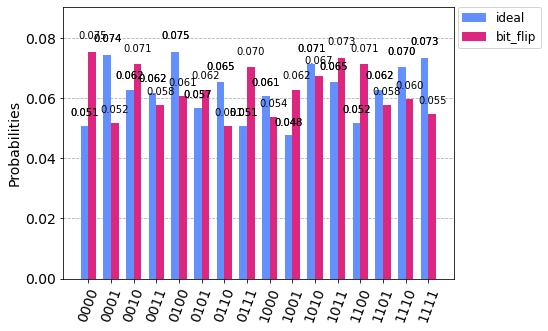

In [91]:
bit_error(swap_qaoa_circ)

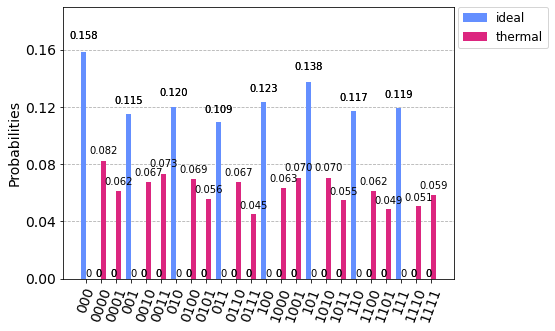

In [92]:
t1_t2(len(swap_qaoa_q), swap_qaoa_circ)

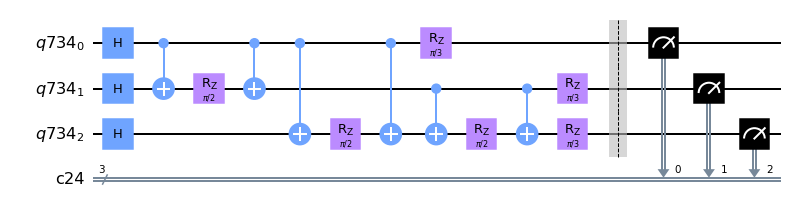

In [93]:
vanilla_qaoa_q = QuantumRegister(3)
vanilla_qaoa_c = ClassicalRegister(3)
vanilla_qaoa_circ = QuantumCircuit(vanilla_qaoa_q, vanilla_qaoa_c)
vanilla_qaoa_circ.h(vanilla_qaoa_q[0:3])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.rz(np.pi/2, 1)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/3, 0)
vanilla_qaoa_circ.rz(np.pi/3, 1)
vanilla_qaoa_circ.rz(np.pi/3, 2)
vanilla_qaoa_circ.barrier()
vanilla_qaoa_circ.measure(vanilla_qaoa_q[0:3], vanilla_qaoa_c[0:3])
display(vanilla_qaoa_circ.draw())

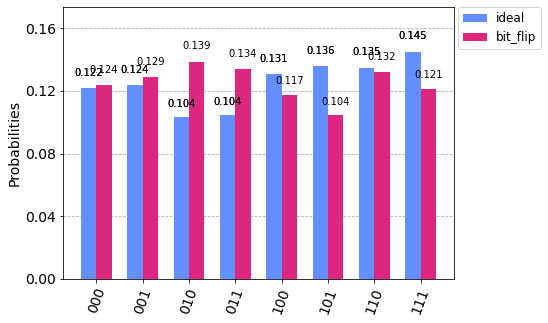

In [94]:
bit_error(vanilla_qaoa_circ)

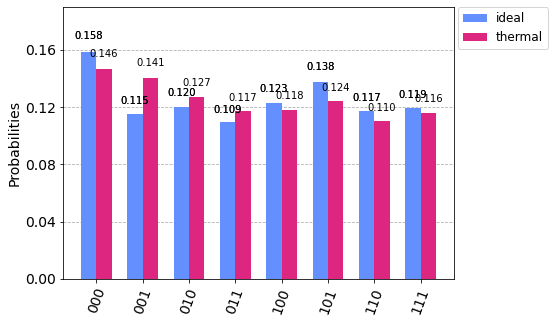

In [95]:
t1_t2(len(vanilla_qaoa_q), vanilla_qaoa_circ)

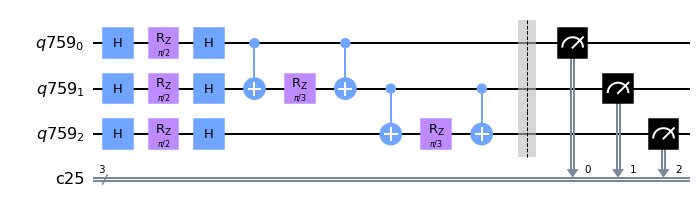

In [96]:
hamilton_q = QuantumRegister(3)
hamilton_c = ClassicalRegister(3)
hamilton_circ = QuantumCircuit(hamilton_q, hamilton_c)
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.rz(np.pi/2, hamilton_q[0:4])
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.rz(np.pi/3, 1)
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.rz(np.pi/3, 2)
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.barrier()
hamilton_circ.measure(hamilton_q[0:3], hamilton_c[0:3])
display(hamilton_circ.draw())

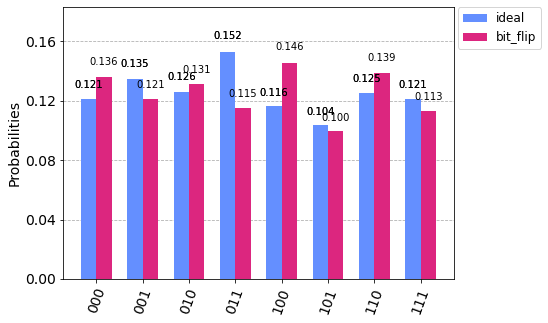

In [97]:
bit_error(hamilton_circ)

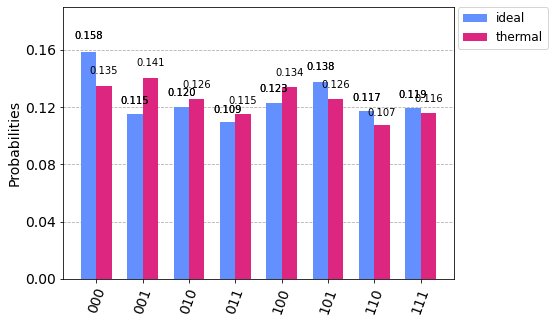

In [98]:
t1_t2(len(hamilton_q), hamilton_circ)